# Import Libraries

In [29]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns

# !pip install nltk
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")
from nltk.tokenize import word_tokenize

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA #PCA
from sklearn.manifold import TSNE #TSNE

import unicodedata

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\belal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Load Dataset

In [2]:
real_news_df = pd.read_csv("real_news.csv")
fake_news_df = pd.read_csv("fake_news.csv")

In [3]:
real_news_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [4]:
fake_news_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


# Prepare Data

In [5]:
real_news_df.drop(['subject', "date"], axis=1, inplace=True)
fake_news_df.drop(['subject', "date"], axis=1, inplace=True)

In [6]:
print("columns of real_news_df:")
real_news_df.info()

columns of real_news_df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   21417 non-null  object
 1   text    21417 non-null  object
dtypes: object(2)
memory usage: 334.8+ KB


In [7]:
print("columns of fake_news_df:")
fake_news_df.info()

columns of fake_news_df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   23481 non-null  object
 1   text    23481 non-null  object
dtypes: object(2)
memory usage: 367.0+ KB


In [8]:
#dropping duplicates
real_news_df.drop_duplicates(inplace=True)
fake_news_df.drop_duplicates(inplace=True)

In [9]:
#add labels to each row in both dataframe
real_news_df['label'] = 1 #1 = real
fake_news_df['label'] = 0 #0 = fake

#concatenate the both dataframe into one dataframe
news_df = pd.concat([real_news_df, fake_news_df])

#concatenate the 'title' and 'text' columns to minimize the processing phase
news_df['text'] = news_df['title'] + ' ' + news_df['text']

#drop the 'title' column
news_df.drop(['title'], axis=1, inplace=True)

news_df.sample(5)

,text,label
8529,Snyder Gets Served Some Very Bad News From Co...,0
16832,Critics urge WHO to reverse choice of Mugabe a...,1
4863,South Dakota's governor vetoes loosening of co...,1
11962,DIAMOND AND SILK Give It To “Underhanded” Mery...,0
1185,Trump Plays Golf Again In Wake Of Damning Com...,0


# Visualize The Data

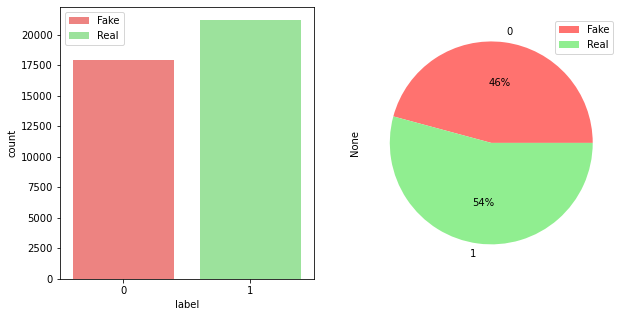

In [10]:
#Plot number the labels (Fake & Real) amoung the data

fig , ax = plt.subplots(1,2, figsize=(10,5))

sns.countplot(x='label', data=news_df, palette=['#ff726f', 'lightgreen'], hue='label', dodge=False, ax=ax[0])
ax[0].legend(['Fake', 'Real'])

news_df.groupby('label').size().plot(kind='pie', autopct='%.0f%%', colors=['#ff726f', 'lightgreen'], ax=ax[1])
ax[1].legend(['Fake', 'Real'])

# Data Cleaning

In [11]:
def remove_tweet_info(text):
    text = re.sub(r"@[^ ]+"," ",text)
    text = re.sub(r"RT"," ",text)
    text = re.sub(r"rt"," ",text)
    text = re.sub(r"\#\w+"," ",text)
    return text

def remove_links(text):
    return re.sub(r"\(|https?://\S+|www\.\S+|bit\.ly\S+", " ", text)

def remove_punctuations(text):
    return re.sub(r"[^\w\s]", "", text)

def remove_double_white_spaces(text):
    return re.sub(r"\s\s+", " ", text)

def normalizer(text):
    return unicodedata.normalize("NFKD", text)

def text_cleaning(data):
    #lowering the text
    data = data.apply(lambda row: row.lower())
    
    data = data.apply(lambda row: remove_tweet_info(row))
    
    data = data.apply(lambda row: remove_links(row))
    
#     data = data.apply(lambda row: remove_punctuations(row))
    
    data = data.apply(lambda row: remove_double_white_spaces(row))
    
    data = data.apply(lambda row: normalizer(row))
    
    data = data.apply(lambda row: row.strip())
    
    return data

news_df.head()

,text,label
0,"As U.S. budget fight looms, Republicans flip t...",1
1,U.S. military to accept transgender recruits o...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,1
3,FBI Russia probe helped by Australian diplomat...,1
4,Trump wants Postal Service to charge 'much mor...,1


In [12]:
news_df['text'] = text_cleaning(news_df['text'])

news_df.head()

,text,label
0,"as u.s. budget fight looms, republicans flip t...",1
1,u.s. military to accept transgender recruits o...,1
2,senior u.s. republican senator: 'let mr. muell...,1
3,fbi russia probe helped by australian diplomat...,1
4,trump wants postal service to charge 'much mor...,1


# Data Transformation

In [13]:
def remove_empty_text(text):
    return len(text) <= 0

def tokenizer(data):
    return data.apply(lambda text: word_tokenize(text))

def text_transformation(data):    
    tokenized_data = data.apply(lambda text: word_tokenize(text))
    
    stop_words = set(stopwords.words('english'))
    tokenized_data_no_sw = tokenized_data.apply(lambda text: [word for word in text if word not in stop_words])
    
    transformed  = tokenized_data_no_sw.apply(lambda text: (" ").join(text))
    
    data = transformed.apply(lambda row: remove_punctuations(row))

    return data

In [14]:
news_df['text'] = text_transformation(news_df['text'])

In [15]:
news_df.shape

(39105, 2)

In [16]:
news_df['text'].replace('', np.nan, inplace=True)
news_df.dropna(subset=['text'], inplace=True)

news_df.shape

(39101, 2)

In [17]:
news_df.head()

,text,label
0,us budget fight looms republicans flip fiscal...,1
1,us military accept transgender recruits monday...,1
2,senior us republican senator let mr mueller j...,1
3,fbi russia probe helped australian diplomat ti...,1
4,trump wants postal service charge much amazon...,1


# Data Vectorization 

In [18]:
# !pip install gensim
from gensim.models import Word2Vec # Word2vec

tokneized_text = tokenizer(news_df['text'])

model_word2Vec = Word2Vec(tokneized_text, min_count=1)

In [19]:
model_word2Vec.wv.most_similar("us")

[('american', 0.5159140825271606),
 ('country', 0.5042078495025635),
 ('america', 0.5027621984481812),
 ('iran', 0.4621979892253876),
 ('overseas', 0.4484272003173828),
 ('united', 0.43804672360420227),
 ('iranian', 0.43324533104896545),
 ('abroad', 0.4231346845626831),
 ('pyongyang', 0.4221166968345642),
 ('russianow', 0.42149031162261963)]

In [20]:
model_word2Vec.wv['us']

array([ 1.6623371 , -1.1292127 ,  0.14470734, -0.19576593, -2.0401783 ,
       -2.4488065 ,  1.4848261 ,  0.17147368, -2.3402436 ,  1.9544723 ,
       -0.56066006, -1.2548589 ,  3.9448798 ,  2.745654  ,  3.0174513 ,
       -0.8057168 , -2.5679228 , -0.61918515, -1.2882051 ,  0.5747227 ,
        0.8196543 ,  0.33622018, -1.2193872 ,  0.09066895,  0.72015566,
       -0.9119114 , -0.3267537 ,  0.8701371 ,  1.4296175 ,  0.50473243,
       -1.7565304 , -0.28621927, -0.44111276, -1.5251217 , -1.1070831 ,
        0.31997025,  1.9122884 ,  0.1153987 ,  0.22745526, -0.24985684,
       -0.9453961 ,  0.6826646 ,  0.6844985 ,  0.58133644, -2.0156634 ,
        3.099348  ,  0.7633898 , -0.4432236 ,  0.64777356, -0.6908448 ,
        2.7033572 , -1.0776067 , -1.3247313 , -0.52064353, -1.9486867 ,
        0.11522185, -0.02123265, -1.3838567 , -1.937314  ,  0.38859567,
       -1.9437664 ,  0.02441411,  0.77229553, -0.29630578,  1.5584874 ,
        0.4556013 , -0.9043873 ,  0.42520657, -0.14901769,  2.33

In [21]:
def getVectors(word):
    try:
        return model_word2Vec.wv[word]
    except:
        return np.zeros(100)
    
def Text_Vector(text):
    text_vectors = list(map(lambda word: getVectors(word), text))
    if(len(text_vectors) > 0):
        return np.average(text_vectors, axis=0).tolist()
    else:
        return False

Vectors = []
for text in tokneized_text:
    res = Text_Vector(text)
    if(res):
        Vectors.append(res)

In [22]:
Vectors_np = np.array(Vectors)

In [23]:
Vectors_np

array([[ 0.17951606,  0.28856263,  0.94081944, ..., -0.38077518,
        -0.68154359, -0.24244161],
       [ 0.21551065, -0.13036704,  0.62604672, ..., -0.79891706,
        -0.2144177 , -0.32271904],
       [ 0.86604726,  0.07418258,  1.30112517, ..., -0.88455528,
        -0.62735045,  0.84790671],
       ...,
       [-0.0783515 ,  0.01960788,  0.19261429, ..., -0.74722219,
         0.11003231,  0.1127229 ],
       [-0.18665239,  0.43102869,  0.51690733, ..., -0.69960892,
        -0.41656902, -0.03157992],
       [ 0.44556767,  0.38819897,  0.41404584, ..., -0.57283729,
        -0.40681866, -0.06302889]])

# Building Model

In [24]:
kmeans_model = KMeans(n_clusters=2, verbose=1)

predicted_labels = kmeans_model.fit_predict(Vectors_np)

Initialization complete
Iteration 0, inertia 663077.8748357064
Iteration 1, inertia 324193.2583882634
Iteration 2, inertia 321976.23158907593
Iteration 3, inertia 321684.4681455823
Iteration 4, inertia 321630.22972227534
Iteration 5, inertia 321620.0365655638
Iteration 6, inertia 321618.0785215904
Iteration 7, inertia 321617.65710019437
Converged at iteration 7: center shift 4.152925875467163e-06 within tolerance 9.490214859248854e-06.
Initialization complete
Iteration 0, inertia 527955.506616363
Iteration 1, inertia 332089.83034685417
Iteration 2, inertia 327195.47834065574
Iteration 3, inertia 324653.1264440109
Iteration 4, inertia 323463.38369046984
Iteration 5, inertia 322748.6011576222
Iteration 6, inertia 322296.6173137136
Iteration 7, inertia 321979.6287342248
Iteration 8, inertia 321800.80523847707
Iteration 9, inertia 321708.77895230387
Iteration 10, inertia 321660.2212418417
Iteration 11, inertia 321637.04399255855
Iteration 12, inertia 321627.00873030163
Iteration 13, inerti

# Model Visualization

Text(0.5, 1.0, 'Visualized using PCA')

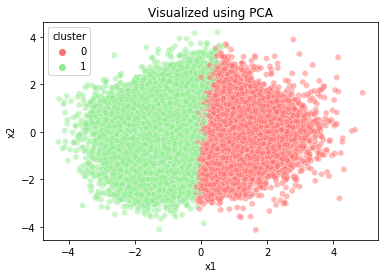

In [43]:
pca_model = PCA(n_components=2)
pca_res = pca_model.fit_transform(Vectors_np)

pca_df = pd.DataFrame(pca_res)
pca_df['cluster'] = predicted_labels
pca_df.columns = ['x1','x2','cluster']

sns.scatterplot(data=pca_df, x='x1', y='x2', hue='cluster', legend="full",alpha=0.5, palette=['#ff726f', 'lightgreen']).set_title("Visualized using PCA")

In [34]:
tsne_model = TSNE(n_components=2)
tsne_res = tsne_model.fit_transform(pca_res)

tsne_df = pd.DataFrame(tsne_res)
tsne_df['cluster'] = predicted_labels
tsne_df.columns = ['x1','x2','cluster']

Text(0.5, 1.0, 'Visualized using TSNE')

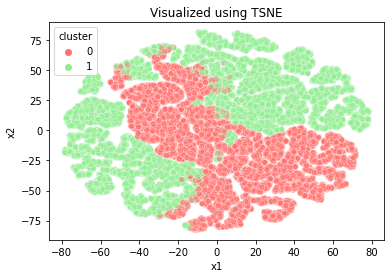

In [44]:
sns.scatterplot(data=tsne_df,x='x1',y='x2',hue='cluster',legend="full",alpha=0.5, palette=['#ff726f', 'lightgreen']).set_title("Visualized using TSNE")

# Model Evaluation

In [26]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
print("Model's prediction accuracy: %.2f%%"%(accuracy_score(news_df['label'], predicted_labels) *100))

Model's prediction accuracy: 85.78%


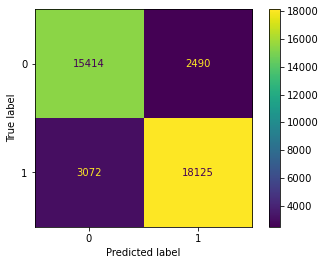

In [27]:
conf_mat = confusion_matrix(news_df['label'], predicted_labels)
ConfusionMatrixDisplay(conf_mat).plot()

# Production Model

In [45]:
#real source: https://edition.cnn.com/2022/05/27/opinions/un-afghanistan-report-indictment-trump-biden-administrations-bergen/index.html
real_article_1 = """
Whether it's providing a safe haven for terrorist groups like al Qaeda or installing officials who face United Nations sanctions in cabinet positions, the Taliban is up to its old ways, according to a new report issued by the UN on Friday. While the report does not mention former President Donald Trump or President Joe Biden by name, it is an indictment of their administrations' failed policies in Afghanistan. The 25-page report says that the Taliban "remains close" with al Qaeda, which now has "increased freedom of action" in Afghanistan. Opinion: The Taliban should release its other detainees Opinion: The Taliban should release its other detainees Underlining that increased freedom of action, the leader of al Qaeda, Ayman al-Zawahiri, "has issued more frequent recorded messages," appearing in eight videos since the Taliban took over Afghanistan last August, according to the UN report. And al Qaeda has renewed its pledge of allegiance to the leader of the Taliban. The UN also points out that an astonishing 41 members of the Taliban who are on the UN sanctions list have been appointed to the cabinet and other senior-level positions in Afghanistan. Among them is Sirajuddin Haqqani, the leader of the Taliban Haqqani Network, which the UN says now controls key Afghan ministries such as the interior ministry and the departments of intelligence, passports and migration. A previous UN report identified Haqqani, Afghanistan's acting interior minister, as being part of the leadership of al Qaeda, marking the first time that the terrorist group has had a member in a senior cabinet position anywhere in the world. Haqqani is also on the FBI's most-wanted list. All of this demonstrates how deeply flawed a strategy it was for the Trump administration to negotiate a "peace" agreement with the Taliban -- and how misguided it was for Biden to abide by that agreement once he assumed office. In 2018, the Trump administration started negotiating directly with the Taliban, eventually coming to an agreement that the United States would withdraw from Afghanistan providing that the Taliban would not let the country become a haven for terrorists and agree to enter into genuine peace negotiations with the Afghan government. Opinion: Biden shouldn&#39;t confuse Taiwan with Ukraine Opinion: Biden shouldn't confuse Taiwan with Ukraine The Trump team signed the agreement with the Taliban in 2020 and Biden, who said he was forced to either abide by that deal or escalate the fighting in Afghanistan, chose to pull out all US troops in August last year. It's worth noting this agreement wasn't ratified by the US Senate, and instead was a deal negotiated with a terrorist/insurgent group that failed to stick to their end of the agreement. It was also a deal that had been struck without any substantive involvement of the elected Afghan government. As the new UN report makes clear, the Taliban did not break with al Qaeda, noting that the terrorist group has instead "used the Taliban's takeover to attract new recruits and funding" while the core al Qaeda leadership "is reported to remain in Afghanistan: more specifically, the eastern region from Zabul Province north towards Kunar and along the border with Pakistan." And of course, the Taliban didn't come to a peace agreement with the Afghan government. As the Americans hastily withdrew from Afghanistan, the Taliban instead overthrew the elected Afghan government. After they seized power in Afghanistan in August, Taliban leaders gave their first press conference and told the assembled journalists bald-faced lies about how they respected women's rights. Taliban spokesman Zabihullah Mujahid said, "Our sisters, our men have the same rights; they will be able to benefit from their rights." Why Arabs aren&#39;t laughing at George W. Bush&#39;s gaffe on Ukraine and Iraq Why Arabs aren't laughing at George W. Bush's gaffe on Ukraine and Iraq This was, of course, nonsense, but some wishful thinkers had bought into the fantasy of some kind of "Taliban 2.0." Instead, we now have just the same old Taliban. They have banned girls from school above the sixth grade; they have insisted that women need a close male relative to escort them if they travel long distances; they have declared that women need to be covered from head to toe and have instituted punishments for male "guardians" who don't enforce this; more than 200 media outlets have closed in Afghanistan, and the Taliban have presided over an economy that is in free fall. The UN report states that the Taliban "are, in large part, the same Taliban movement that was deposed in 2001." The UN also notes that the top posts in the Taliban government "have been given to the Taliban's 'old guard.'" Meanwhile, the Taliban continue to allow foreign terrorist groups to use Afghanistan as a base. The largest such group is the Pakistani Taliban, which numbers several thousand fighters, according to the UN. For the past six months, the Taliban have also imprisoned without charge five British citizens, including businessman Peter Jouvenal, a friend of mine who once worked with CNN as a cameraman. The Taliban have also held American contractor Mark Frerichs for more than two years. The UN report does have some qualified good news, concluding that the Afghanistan branch of ISIS and al Qaeda are not believed to be "capable of mounting international attacks until 2023 at the earliest." Get our free weekly newsletter Sign up for CNN Opinion's newsletter. Join us on Twitter and Facebook This is a more optimistic projection than the one delivered by a top Pentagon official, Colin Kahl, in October 2021. Kahl testified before a US congressional committee that ISIS's affiliate in Afghanistan could mount external operations "somewhere between six and 12 months" while "al Qaeda would take a year or two to reconstitute that capability." That said, the Taliban is in a stronger position today than the last time it was in power. That was before the 9/11 attacks, when it was fighting the Northern Alliance, a not insignificant opposition force. The Taliban today hasn't significantly changed any of its social policies, nor has it abandoned its alliance with al-Qaeda. We have seen how this movie plays out in the past. To paraphrase an observation attributed to Mark Twain, while history may not repeat itself, it certainly may rhyme.
"""

# real source: https://www.bbc.com/news/world-europe-61618907
real_article_2 = """
Ukraine war: Putin urged to hold 'direct, serious negotiations' with Zelensky,
The leaders of France and Germany have urged Russia's Vladimir Putin to hold "direct [and] serious negotiations" with Ukraine's president, the German chancellor's office said. Emmanuel Macron and Olaf Scholz spoke to Mr Putin by phone for 80 minutes. The pair "insisted on an immediate ceasefire and a withdrawal of Russian troops," the chancellor's office said. Russia's leader said Moscow was open to resuming dialogue with Kyiv, according to the Kremlin. It did not mention the possibility of direct talks between Mr Putin and his Ukrainian counterpart Volodymyr Zelensky. The Ukrainian president earlier said he was not "eager" for talks, but added they would likely be necessary to end the conflict. Russian and Ukrainian delegations have held multiple rounds of talks remotely and in person since Russia invaded on 24 February, but efforts have stalled of late. France and Germany also urged Mr Putin to release 2,500 Ukrainian fighters taken as prisoners of war at the Azovstal steelworks in Mariupol. The sprawling factory became the last holdout in the southern port city, which endured relentless bombardment from Russian forces and now lies in ruins. Mariupol: 80 days that left a flourishing city in ruins What next for Ukraine's captured Azovstal fighters? Earlier this month, Moscow officials said the last fighters defending the plant had surrendered, while President Zelensky said they had been given permission to leave. Russia has previously said more than 900 of the fighters were moved to a reopened prison colony in Olenivka, a village in Russian-occupied Donetsk. A smaller number with serious wounds were taken to a hospital in the town of Novoazovsk, also in Donetsk. Ukraine hopes they will be released as part of a prisoner exchange - but Russia has not confirmed that. Some Russian lawmakers argue the fighters should be tried or even executed. A drone image shows destroyed facilities at the Azovstal Iron and Steel Works in the southern port city of Mariupol, Ukraine IMAGE SOURCE,REUTERS Image caption, Ukraine wants the fighters who defended the Azovstal steelworks to be part of a prisoner exchange - but Russia has made no public commitments Elsewhere in the call, the French and German leaders asked Mr Putin to lift Russia's blockade of the Ukrainian port of Odesa, to allow for grain exports. The Kremlin said Mr Putin offered to look at options, to help address the risk of a global food crisis - but demanded that the West lift sanctions. Russia also warned France and Germany against increasing weapons supplies to Ukraine, saying that could increase instability still further. line This war has created alternate realities Analysis by Joe Inwood, Ukraine Correspondent To read the Kremlin's report of the call between Presidents Putin and Macron and Chancellor Scholz, Russia is engaged in a peacekeeping mission in Ukraine. Its actions in the southern port of Mariupol - a city that has been reduced to rubble - are all about "establishing peaceful life" and "liberation". It is a stark contrast not just with the readout from the EU allies - who said the focus was on the welfare of the 2,500 prisoners of war who surrendered - but with the evidence of all independent observers. There are multiple, credible reports of war crimes carried out by occupying Russian forces. Despite that, the fact that the two most powerful leaders in the EU are holding direct talks with Russia's president is significant. Their call for a diplomatic solution - even as Russian forces advance in the Donbas - is not supported by all Western allies, who fear it could put pressure on Ukraine to cede territory in return for peace. It all comes as Moscow claims to have captured the crucial crossroads city of Lyman - and continues its assault of Severodonesk. The industrial city has been encircled for days - with reports that Ukraine may order a strategic withdrawal of its forces. It is too soon to say that today's attempts at diplomacy represent a fracturing of the western alliance… but different positions are beginning to emerge. line Ukrainian officials say there has been fighting on the streets in the eastern city of Severodonetsk, the easternmost place still under Ukrainian control. The governor of the Luhansk region, Serhiy Haidai, said Russia had been firing heavily on the city, although its forces had suffered significant losses. On Friday, officials said two-thirds of its perimeter was surrounded by Russian forces. Mr Haidai said Ukrainian troops could withdraw from Severodonetsk, observing: "It is possible that in order not to be surrounded, they will have to leave." In comments to the BBC on Saturday, Ukraine's Prime Minister Denys Shmyhal said the Russian invasion of his country had destroyed more than 25,000 km (15,000 miles) of roads, several hundred bridges, and 12 airports. More than 100 educational institutions, over 500 medical facilities, and 200 factories have also been ruined or damaged, he said. He called for Russia to be forced to pay for "the destruction it has created", saying frozen Russian assets should be transferred to Ukraine to fund reconstruction work.
"""

#fake source: https://www.thefakenewsgenerator.com/
fake_article_1 = """
Once Thriving Cheeto Driven To Extinction By Unregulated Snack Food Industry CHESTER, IA—Where once the cheeto could be found in great numbers, filling the crisp autumn air with a dangerously cheesy aroma, today there isn’t a trace of fluorescent orange to be seen, as overharvesting has all but eliminated the region’s
"""

#fake source: https://www.thefakenewsgenerator.com/
fake_article_2 = """
Eldest Grandson Reigns Supreme With 3 School Pictures On Nana’s Fridge
ROCKFORD, MI—After months of intense combat and speculation, James once again emerged as the favored grandson, with a record-setting four pictures on Nana's fridge.
"""


testing_news = [real_article_1, fake_article_1, real_article_2 ,fake_article_2]

text = pd.Series(testing_news)
text = text_cleaning(text)
text = text_transformation(text)
text = tokenizer(text)

ready_news = []
for news in text:
    ready_news.append(Text_Vector(news))
    
    
ready_news = np.array(ready_news)

predictions = kmeans_model.predict(ready_news)

#expacted output: Real, Fake, Real, Fake
for i in range(len(testing_news)):
    print(f"{i+1} is:", ("Real" if predictions[i] == 1 else "Fake"))

1 is: Real
2 is: Fake
3 is: Real
4 is: Fake
